# Using physics informed neural networks (PINNs) to solve parabolic PDEs

Import necessary packages and set problem specific data

In [21]:
# Import TensorFlow and NumPy
import tensorflow as tf
import numpy as np

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

# Set constants
pi = tf.constant(np.pi, dtype=DTYPE)
viscosity = 1

# Define initial condition
def fun_u_0(x):
    return -tf.sin(pi * x)

# Define boundary condition
def fun_u_b(t, x):
    n = x.shape[0]
    return tf.zeros((n,1), dtype=DTYPE)

# Define residual of the PDE
def fun_r(t, x, u, u_t, u_x, u_xx):
    return u_t + u * u_x - viscosity * u_xx

### Generate a set of collocation points

We assume that the collocation points $X_r$ as well as the points for the initial time and boundary data $X_0$ and $X_b$ are generated by random sampling from a uniform distribution.
Although uniformly distributed data are sufficient in our experiments, the authors of
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561))
employed a space-filling Latin hypercube sampling strategy ([Stein, 1987](https://www.tandfonline.com/doi/abs/10.1080/00401706.1987.10488205)) but for simplicity the code examples accompanying this paper employ uniform sampling throughout.
We choose training data of size $N_0 = N_b =50$ and $N_f=10000$.

In [22]:
# Set number of data points
N_0 = 50
N_b = 50
N_r = 10000

# Set boundary
tmin = 0.
tmax = 1.
xmin = 0.
xmax = 1.

# Lower bounds
lb = tf.constant([tmin, xmin], dtype=DTYPE)
# Upper bounds
ub = tf.constant([tmax, xmax], dtype=DTYPE)

# Set random seed for reproducible results
tf.random.set_seed(0)

# Draw uniform sample points for initial boundary data
t_0 = tf.ones((N_0,1), dtype=DTYPE)*lb[0]
x_0 = tf.random.uniform((N_0,1), lb[1], ub[1], dtype=DTYPE)
X_0 = tf.concat([t_0, x_0], axis=1)

# Evaluate intitial condition at x_0
u_0 = fun_u_0(x_0)

# Boundary data
t_b = tf.random.uniform((N_b,1), lb[0], ub[0], dtype=DTYPE)
x_b = lb[1] + (ub[1] - lb[1]) * tf.keras.backend.random_bernoulli((N_b,1), 0.5, dtype=DTYPE)
X_b = tf.concat([t_b, x_b], axis=1)

# Evaluate boundary condition at (t_b,x_b)
u_b = fun_u_b(t_b, x_b)

# Draw uniformly sampled collocation points
t_r = tf.random.uniform((N_r,1), lb[0], ub[0], dtype=DTYPE)
x_r = tf.random.uniform((N_r,1), lb[1], ub[1], dtype=DTYPE)
X_r = tf.concat([t_r, x_r], axis=1)

# Collect boundary and inital data in lists
X_data = [X_0, X_b]
u_data = [u_0, u_b]

### Set up network architecture

In this example, adopted from 
([Raissi et al., 2017 (Part I)](https://arxiv.org/abs/1711.10561)), we assume a feedforward neural network of the following structure:
- the input is scaled elementwise to lie in the interval $[-1,1]$,
- followed by 8 fully connected layers each containing 20 neurons and each followed by a hyperbolic tangent activation function,
- one fully connected output layer.

This setting results in a network with $3021$ trainable parameters (first hidden layer: $2 \cdot 20 + 20 = 60$; seven intermediate layers: each $20 \cdot 20 + 20 = 420$; output layer: $20 \cdot 1 + 1 = 21$).

In [23]:
def init_model(num_hidden_layers=8, num_neurons_per_layer=20):
    # Initialize a feedforward neural network
    model = tf.keras.Sequential()

    # Input is two-dimensional (time + one spatial dimension)
    model.add(tf.keras.Input(2))

    # Introduce a scaling layer to map input to [lb, ub]
    scaling_layer = tf.keras.layers.Lambda(
                lambda x: 2.0*(x - lb)/(ub - lb) - 1.0)
    model.add(scaling_layer)

    # Append hidden layers
    for _ in range(num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_neurons_per_layer,
            activation=tf.keras.activations.get('tanh'),
            kernel_initializer='glorot_normal'))

    # Output is one-dimensional
    model.add(tf.keras.layers.Dense(1))
    
    return model

### Define routines to determine loss and gradient


In [24]:
def get_r(model, X_r):
    
    # A tf.GradientTape is used to compute derivatives in TensorFlow
    with tf.GradientTape(persistent=True) as tape:
        # Split t and x to compute partial derivatives
        t, x = X_r[:, 0:1], X_r[:,1:2]

        # Variables t and x are watched during tape
        # to compute derivatives u_t and u_x
        tape.watch(t)
        tape.watch(x)

        # Determine residual 
        u = model(tf.stack([t[:,0], x[:,0]], axis=1))

        # Compute gradient u_x within the GradientTape
        # since we need second derivatives
        u_x = tape.gradient(u, x)
            
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)

    u_x = 0
    del tape

    return fun_r(t, x, u, u_t, u_x, u_xx)

In [25]:
def compute_loss(model, X_r, X_data, u_data):
    
    # Compute phi^r
    r = get_r(model, X_r)
    phi_r = tf.reduce_mean(tf.square(r))
    
    # Initialize loss
    loss = phi_r
    
    # Add phi^0 and phi^b to the loss
    for i in range(len(X_data)):
        u_pred = model(X_data[i])
        loss += tf.reduce_mean(tf.square(u_data[i] - u_pred))
    
    return loss

In [26]:
def get_grad(model, X_r, X_data, u_data):
    
    with tf.GradientTape(persistent=True) as tape:
        # This tape is for derivatives with
        # respect to trainable variables
        tape.watch(model.trainable_variables)
        loss = compute_loss(model, X_r, X_data, u_data)

    g = tape.gradient(loss, model.trainable_variables)
    del tape

    return loss, g

### Set up optimizer and train model

Next we initialize the model, set the learning rate to the step function

$$
\delta(n) = 0.01 \, \textbf{1}_{\{n < 1000\}} + 0.001 \, \textbf{1}_{\{1000 \le n < 3000\}} + 0.0005 \, \textbf{1}_{\{3000 \le n\}}
$$

which decays in a piecewise constant fashion, and set up a `tf.keras.optimizer` to train the model.

In [27]:
# Initialize model aka u_\theta
model = init_model()

# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000,3000],[1e-2,1e-3,5e-4])

# Choose the optimizer
optim = tf.keras.optimizers.Adam(learning_rate=lr)

In [28]:
from time import time

# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
    # Compute current loss and gradient w.r.t. parameters
    loss, grad_theta = get_grad(model, X_r, X_data, u_data)
    
    # Perform gradient descent step
    optim.apply_gradients(zip(grad_theta, model.trainable_variables))
    
    return loss

# Number of training epochs
N = 2500
hist = []

# Start timer
t0 = time()

for i in range(N+1):
    
    loss = train_step()
    
    # Append current loss to hist
    hist.append(loss.numpy())
    
    # Output current loss after 50 iterates
    if i%50 == 0:
        print('It {:05d}: loss = {:10.8e}'.format(i,loss))
        
# Print computation time
print('\nComputation time: {} seconds'.format(time()-t0))

It 00000: loss = 7.27138519e-01
It 00050: loss = 1.36521697e-01
It 00100: loss = 6.74215779e-02
It 00150: loss = 5.10988720e-02
It 00200: loss = 8.39348957e-02
It 00250: loss = 2.56018877e-01
It 00300: loss = 9.48421508e-02
It 00350: loss = 4.39636186e-02
It 00400: loss = 4.77550328e-02
It 00450: loss = 2.34282166e-02
It 00500: loss = 7.05739809e-03
It 00550: loss = 8.02042242e-03
It 00600: loss = 1.21323541e-02
It 00650: loss = 2.81467987e-03
It 00700: loss = 5.01460209e-03
It 00750: loss = 1.74781960e-03
It 00800: loss = 1.31411133e-02
It 00850: loss = 1.10810017e-03
It 00900: loss = 5.24565391e-03
It 00950: loss = 1.07940368e-03
It 01000: loss = 6.10042037e-03
It 01050: loss = 3.39733611e-04
It 01100: loss = 2.75116472e-04
It 01150: loss = 2.65555078e-04
It 01200: loss = 2.57832929e-04
It 01250: loss = 2.50987767e-04
It 01300: loss = 2.44672294e-04
It 01350: loss = 2.38737397e-04
It 01400: loss = 2.33098719e-04
It 01450: loss = 2.27709010e-04
It 01500: loss = 2.22536532e-04
It 01550

### Plot solution

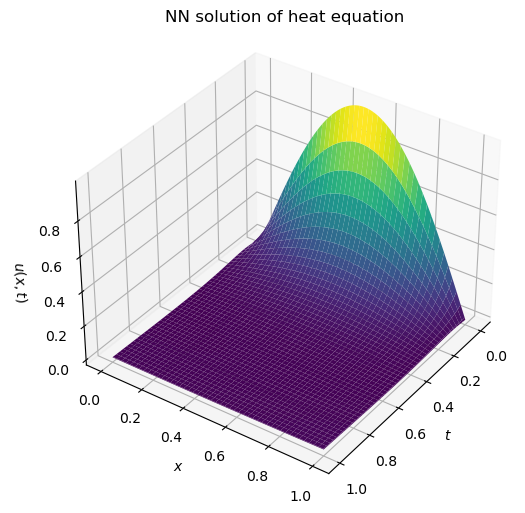

In [29]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# Set up meshgrid
N = 600
tspace = np.linspace(lb[0], ub[0], N + 1)
xspace = np.linspace(lb[1], ub[1], N + 1)
T, X = np.meshgrid(tspace, xspace)
Xgrid = np.vstack([T.flatten(),X.flatten()]).T

# Determine predictions of u(t, x)
upred = model(tf.cast(Xgrid,DTYPE))

# Reshape upred
U = upred.numpy().reshape(N+1,N+1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, -U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u(x,t)$')
ax.set_title('NN solution of heat equation');
#plt.savefig('Burgers_Solution.pdf', bbox_inches='tight', dpi=300);

<Figure size 640x480 with 0 Axes>

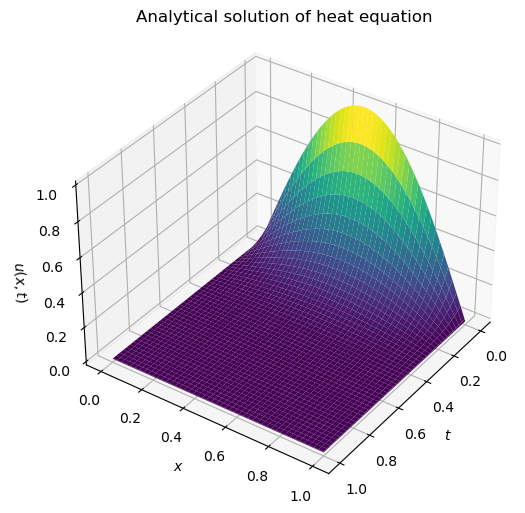

(601, 601)


'The MSE is: 0.053153390316205244'

In [33]:
def analytical_solution(x,t):
    pi = np.pi
    return np.sin(pi * x)*np.exp(-pi**2*t)

from sklearn.metrics import mean_squared_error
#sklearn.metrics.mean_squared_error(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average', squared=True)

def plot_analytical(x_min,x_max,t_min,t_max, N):
    plt.figure()
    
    N = 600
    tspace = np.linspace(t_min, t_max, N + 1)
    xspace = np.linspace(x_min, x_max, N + 1)
    mx, mt = np.meshgrid(xspace,tspace)
    u = analytical_solution(mx,mt)
    
    fig = plt.figure(figsize=(9,6))

    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(mt, mx, u, cmap='viridis')
    ax.view_init(35,35)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_zlabel('$u(x,t)$')
    ax.set_title('Analytical solution of heat equation')
    plt.show()
    return u


def find_MSE(u_analytical, u_NN):
    mse = mean_squared_error(u_NN, u_analytical)
    return f'The MSE is: {mse}'

u_analytical = plot_analytical(0,1,0,1,600)
u_NN = U
print(u_NN.shape)

#print(u_NN.shape, u_analytical.shape)
find_MSE(u_NN, u_analytical)


### Plot the evolution of loss

Text(0.5, 1.0, 'Evolution of loss')

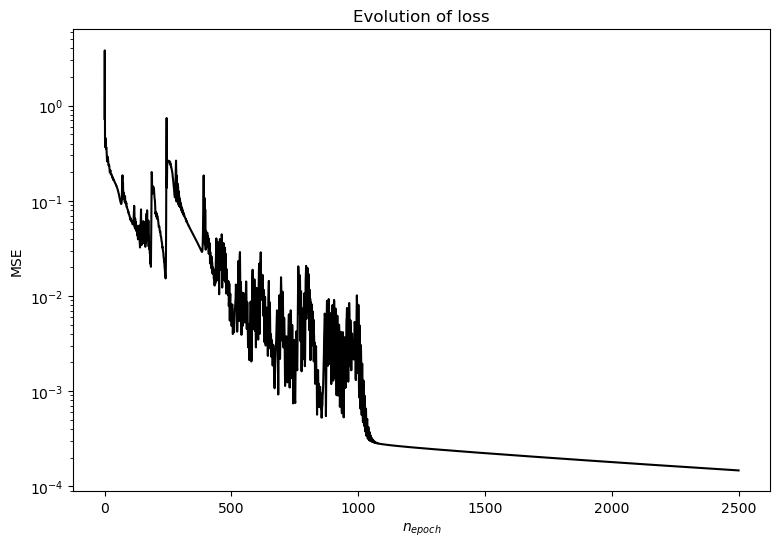

In [31]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{epoch}$')
ax.set_ylabel('MSE')
ax.set_title('Evolution of loss')